# Feature Importance Analysis: Distinguishing Between Upskilling and Reskilling Programs
This notebook analyzes features that distinguish between upskilling and reskilling programs using two approaches:

1. Using all variables (including outcomes)
2. Using only program characteristics (excluding outcomes)

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import variable definitions
from variable_definitions import (
    label_mapping, program_variables, outcomes_to_exclude, add_unique_keys
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Preparation
We'll first load the data and define our mapping dictionaries for feature labels.

In [2]:
# Load data
data = pd.read_stata("../Data/V1_qualflags_analysis2_ML.dta")
df, meta = pyreadstat.read_dta("../Data/V1_qualflags_analysis2_ML.dta")
variable_labels = dict(zip(data.columns, meta.column_labels))

# Define label mapping for better readability
label_mapping = add_unique_keys(label_mapping, variable_labels)

# Display program distribution
program_dist = data['program'].value_counts()
print(program_dist)
print(f"\nProgram Balance: {(program_dist['Reskilling']/program_dist['Upskilling']):.2f}:1")

program
Reskilling    673
Upskilling    464
General        72
Name: count, dtype: int64

Program Balance: 1.45:1


## Analysis 1: Complete Dataset (Including Outcomes)
This first analysis uses all variables, including outcome variables, to identify the key differentiating features between upskilling and reskilling programs.

In [3]:
def preprocess_data(data, analyze=False):
    """
    Preprocess data for model training
    """
    # Create copy to avoid modifying original data
    df = data.copy()
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # For numeric columns, fill with median
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns, fill with mode
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else None)
    
    # Create dummy variables for categorical columns
    df_dummies = pd.get_dummies(df)
    
    # Clean column names
    df_dummies.columns = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_').replace(' ', '_') 
                          for col in df_dummies.columns]
    
    # Convert boolean to integer
    df_dummies = df_dummies.replace({True: 1, False: 0})
    
    return df_dummies

# Create target variable - Reskilling = 1, Upskilling = 0
def create_target(data):
    """Create binary target variable from program type"""
    return np.where(data['program'] == 'Reskilling', 1, 0)


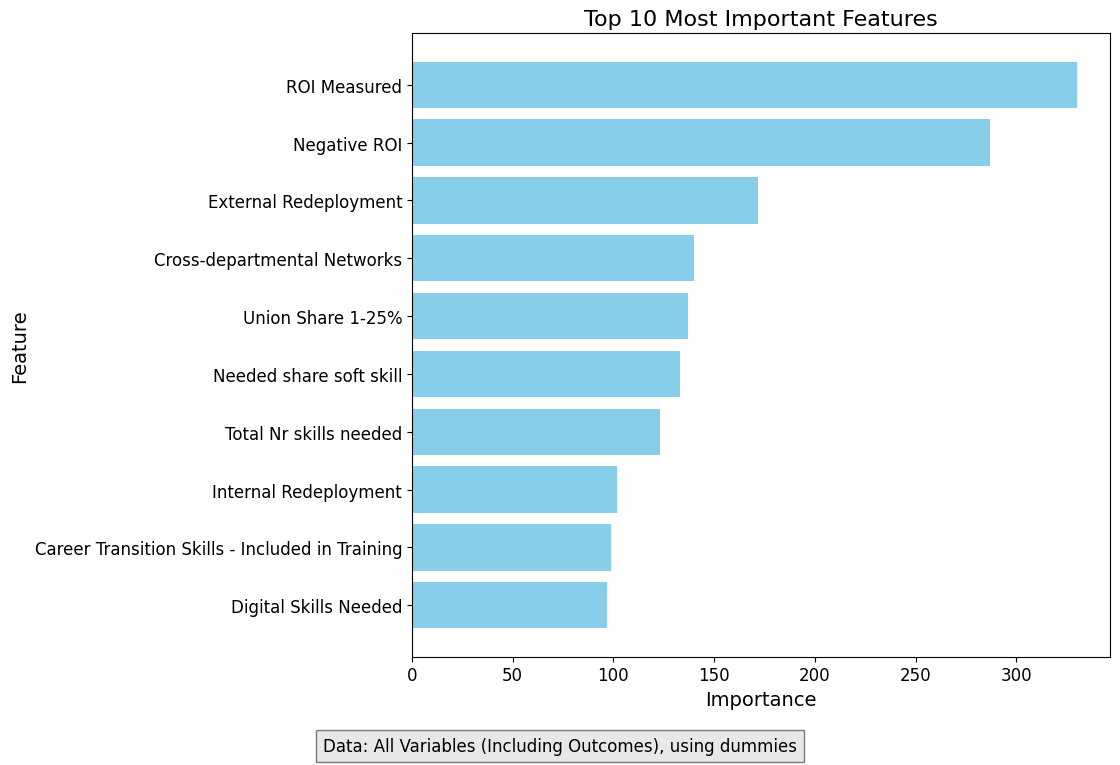

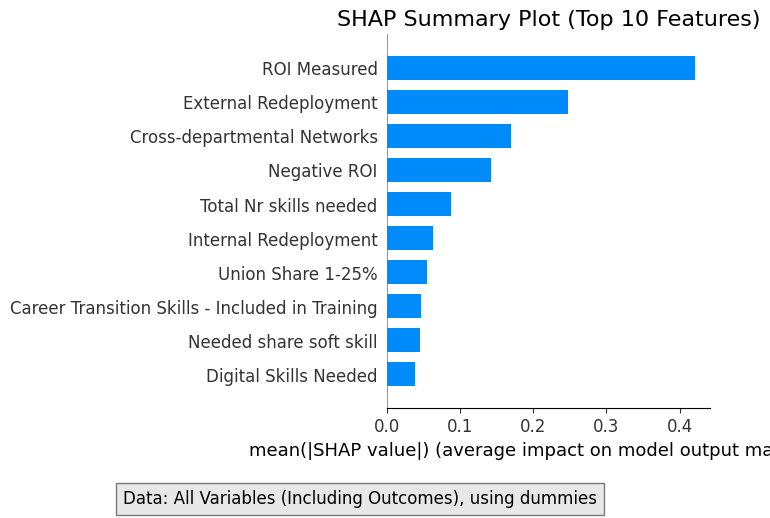

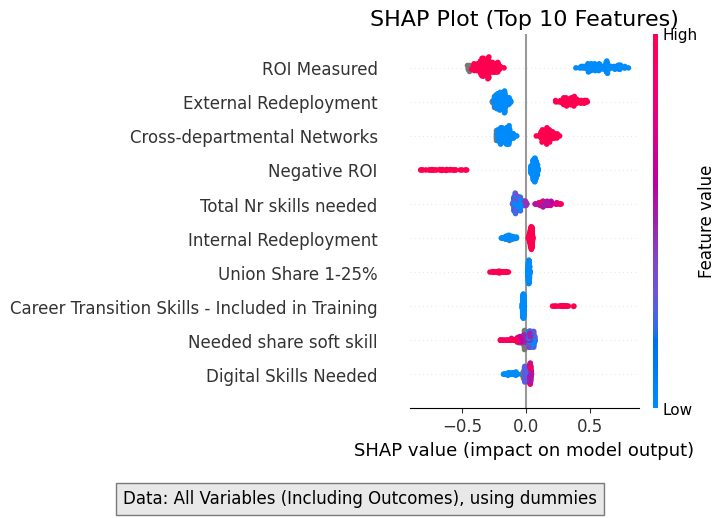

In [4]:
# Preprocess data
preprocessed_data = preprocess_data(data)
target = create_target(data)

# Remove target columns from feature set
X = preprocessed_data.drop(['program_Reskilling', 'program_Upskilling', 'program_General'], axis=1, errors='ignore')
y = target

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost model
model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Get feature importances and sort them
feature_importance = model.get_booster().get_score(importance_type='weight')
feature_importance = {label_mapping.get(k, k): v for k, v in feature_importance.items()}
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_10_features = sorted_features[:10]
features, importances = zip(*top_10_features)
ordered_feature_names = list(features)

# Plot feature importance with improved formatting
plt.figure(figsize=(12, 8))  # Increased figure size
plt.barh(list(reversed(ordered_feature_names)), list(reversed(importances)), color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)  # Increased padding
plt.figtext(0.5, 0.01, "Data: All Variables (Including Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('top10_features_all_data.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)

# Create feature name mapping
feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val.columns)}

# Find indices of top 10 features
top_feature_indices = []
for feature_name in ordered_feature_names:
    # Try exact match first
    if feature_name in feature_map:
        top_feature_indices.append(feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            top_feature_indices.append(feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 10 features
X_val_top10 = X_val.iloc[:, top_feature_indices]
shap_values_top10 = shap_values.values[:, top_feature_indices]

# Create SHAP explanation object with correct ordering
shap_values_top10_obj = shap.Explanation(
    values=shap_values_top10,
    base_values=shap_values.base_values,
    data=X_val_top10.values,
    feature_names=ordered_feature_names
)

# Plot 1: SHAP bar plot with ordered features
plt.figure(figsize=(14, 8))  # Larger figure size
shap.summary_plot(
    shap_values_top10_obj,
    X_val_top10,
    feature_names=ordered_feature_names,
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)  # Increased padding
plt.figtext(0.5, 0.01, "Data: All Variables (Including Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_summary_top10_ordered.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: SHAP plot with SAME top 10 features and SAME order
plt.figure(figsize=(14, 10))  
shap.summary_plot(
    shap_values_top10_obj,  # Use the SAME top 10 SHAP values object
    X_val_top10,            # Use the SAME top 10 features data
    feature_names=ordered_feature_names,  # Use the SAME feature names
    max_display=10,  # Only show top 10
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)  # Increased padding
plt.figtext(0.5, 0.01, "Data: All Variables (Including Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_beeswarm_top10.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis 2: Program Characteristics Only (Excluding Outcomes)
This second analysis focuses only on program characteristics, excluding outcome variables, to identify key differentiating features.

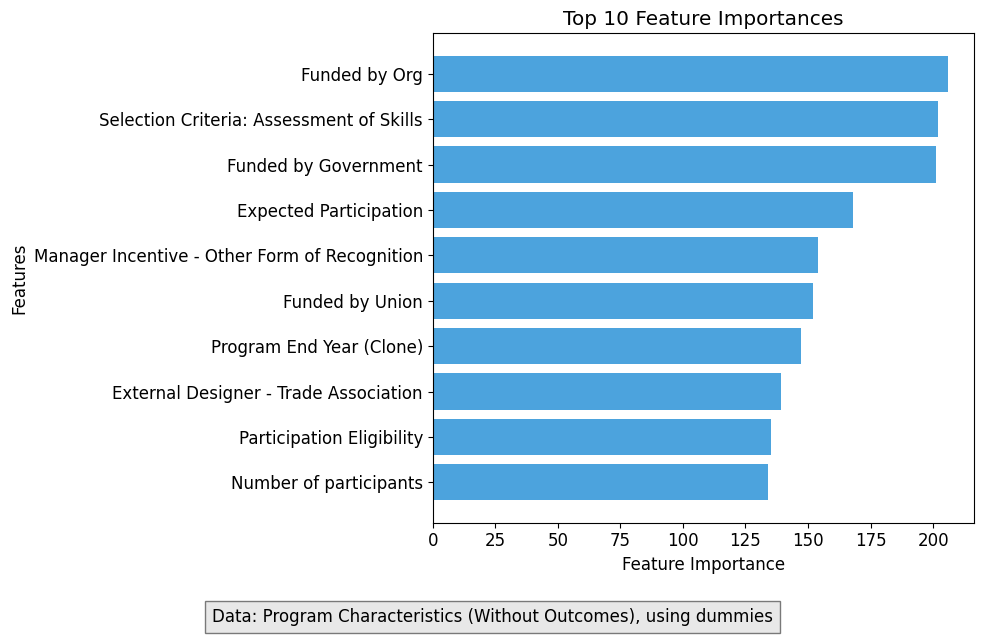

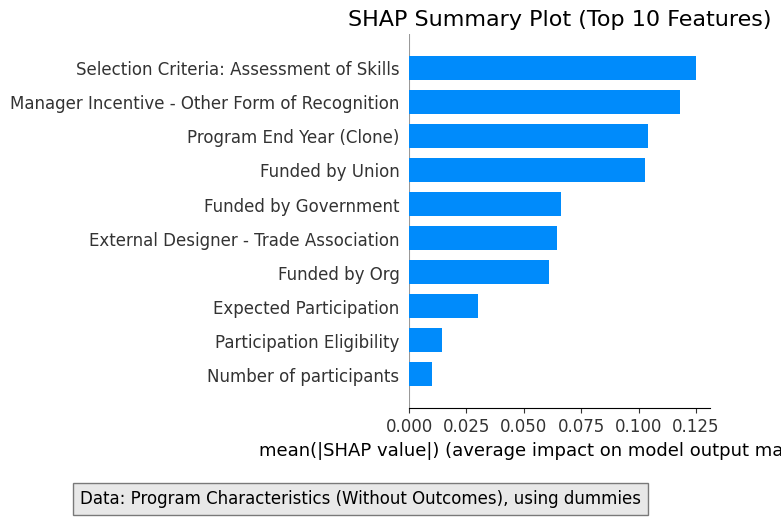

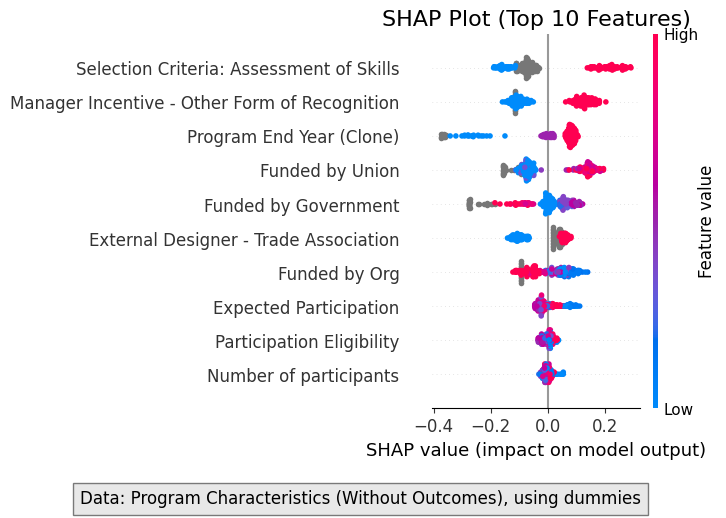

In [5]:
# Create dummy variables
data_dummies = pd.get_dummies(data)

# Clean column names
data_dummies.columns = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_').replace(' ', '_') 
                        for col in data_dummies.columns]
data_dummies = data_dummies.replace({True: 1, False: 0})

# Create target variable
outcomes = [1 if out == 'Reskilling' else 0 for out in data['program']]

# Filter dataset to include only program variables and exclude outcome variables
program_columns = [col for col in data_dummies.columns if any(col.startswith(p) for p in program_variables)]
program_columns = [col for col in program_columns if col not in outcomes_to_exclude]
program_data = data_dummies[program_columns]

# Split data
X_train_prog, X_val_prog, y_train_prog, y_val_prog = train_test_split(
    program_data, outcomes, test_size=0.2, random_state=42, stratify=outcomes
)

# Train XGBoost model on program characteristics only
prog_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

prog_model.fit(X_train_prog, y_train_prog, eval_set=[(X_val_prog, y_val_prog)], verbose=False)

# Get feature importances
prog_feature_importance = prog_model.get_booster().get_score(importance_type='weight')
prog_feature_importance = {label_mapping.get(k, k): v for k, v in prog_feature_importance.items()}
prog_sorted_features = sorted(prog_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 10 features
prog_top_10_features = prog_sorted_features[:10]
prog_features, prog_importances = zip(*prog_top_10_features)
ordered_prog_features = list(prog_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(ordered_prog_features)), list(reversed(prog_importances)), color='#4CA3DD')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.figtext(0.5, -0.05, "Data: Program Characteristics (Without Outcomes), using dummies", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig('top10_features_program_chars.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate SHAP values for program characteristics
prog_explainer = shap.Explainer(prog_model, X_train_prog)
prog_shap_values = prog_explainer(X_val_prog)

# Create feature name mapping
prog_feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val_prog.columns)}

# Find indices of top 10 features
prog_top_feature_indices = []
for feature_name in ordered_prog_features:
    # Try exact match first
    if feature_name in prog_feature_map:
        prog_top_feature_indices.append(prog_feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in prog_feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            prog_top_feature_indices.append(prog_feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 10 features
X_val_prog_top10 = X_val_prog.iloc[:, prog_top_feature_indices]
prog_shap_values_top10 = prog_shap_values.values[:, prog_top_feature_indices]

# Create SHAP explanation object with correct ordering
prog_shap_values_top10_obj = shap.Explanation(
    values=prog_shap_values_top10,
    base_values=prog_shap_values.base_values,
    data=X_val_prog_top10.values,
    feature_names=ordered_prog_features
)

# Plot 1: SHAP bar plot with ordered features
plt.figure(figsize=(14, 8))
shap.summary_plot(
    prog_shap_values_top10_obj,
    X_val_prog_top10,
    feature_names=ordered_prog_features,
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_summary_top10_program_chars.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: SHAP plot with SAME top 10 features and SAME order
plt.figure(figsize=(14, 10))
shap.summary_plot(
    prog_shap_values_top10_obj,  # Use the SAME top 10 SHAP values object
    X_val_prog_top10,            # Use the SAME top 10 features data
    feature_names=ordered_prog_features,  # Use the SAME feature names
    max_display=10,  # Only show top 10
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_beeswarm_top10_program_chars.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis 3: Program Characteristics with Original Categorical Variables (No Dummies)
This analysis preserves the categorical nature of variables without converting to dummies


Features used in model training:
['p_participated', 'p_participated_2023', 'p_mandavolunt', 'p_year_start', 'p_year_end', 'p_year_start_clone2', 'p_year_end_clone2', 'p_ongoing', 'p_program_length', 'p_hourstrained', 'p_duration', 'p_comphours', 'p_otjactivities', 'p_cost', 'p_adequatefund', 'p_adequatefunddummy', 'p_fund_gov', 'p_fund_org', 'p_fund_wrk', 'p_fund_union', 'p_fund_other', 'p_advocacy', 'p_advocacy_hier', 'p_responsibility', 'p_responsibility_hier', 'p_application', 'p_selection', 'p_criteria_jobtitle', 'p_criteria_tenure', 'p_criteria_qualifications', 'p_criteria_assmskills', 'p_criteria_assmsmotivation', 'p_criteria_managerrec', 'p_criteria_other', 'p_targetemp_c', 'p_targetemp_bul', 'p_targetemp_mm', 'p_targetemp_emp', 'p_targetfunc_leg', 'p_targetfunc_hr', 'p_targetfunc_adm', 'p_targetfunc_it', 'p_targetfunc_op', 'p_targetfunc_mrksal', 'p_targetfunc_rd', 'p_targetfunc_accfin', 'p_targetfunc_cust', 'p_difloc', 'p_difstand', 'p_eligibility', 'p_part', 'p_part_exp', 'dd_

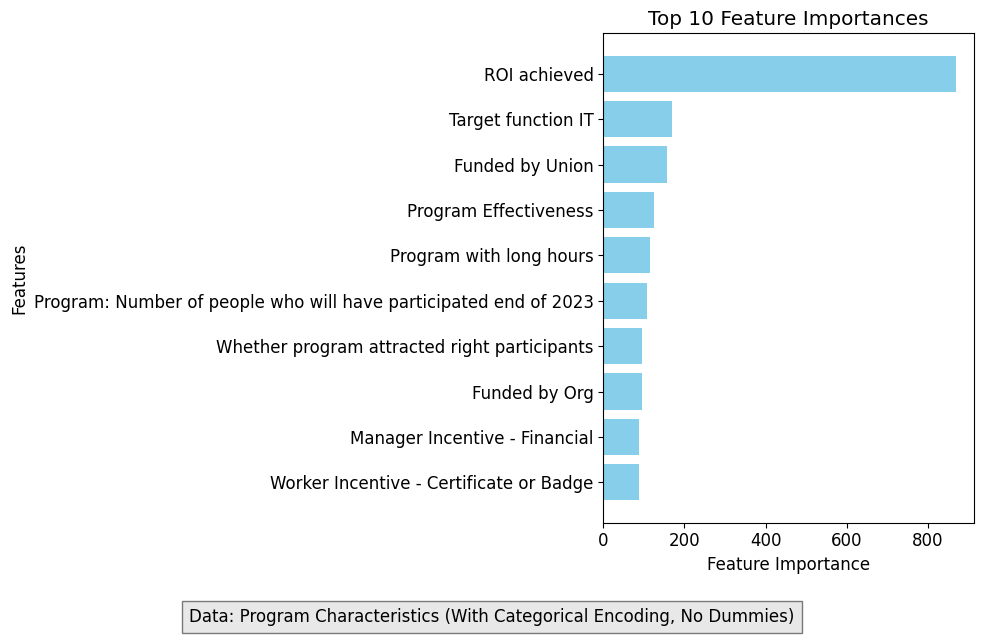

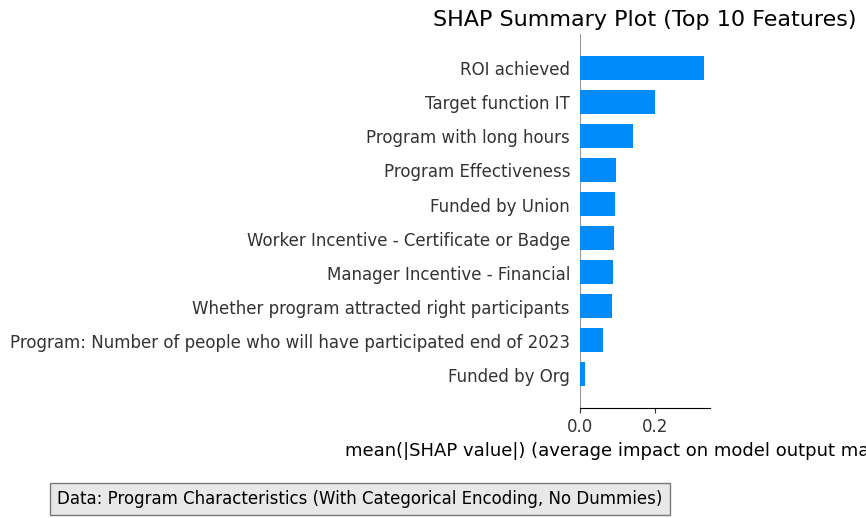

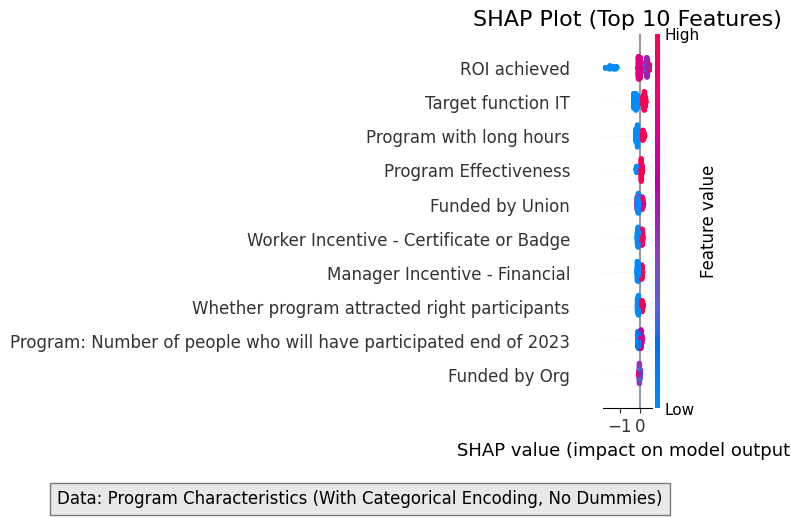

In [6]:
# Filter to select only program-specific variables
program_cols = [col for col in data.columns if any(col.startswith(p.split('_')[0]) for p in program_variables)]
program_data_original = data[program_cols].copy()

# Exclude outcome variables AND the target variable and closely related variables
program_data_original = program_data_original[[col for col in program_data_original.columns 
                                             if col not in outcomes_to_exclude 
                                             and col != 'program'
                                             and 'program type' not in col.lower()]]

# Handle missing values
for col in program_data_original.columns:
    if program_data_original[col].dtype == 'object' or program_data_original[col].dtype.name == 'category':
        # For object/categorical columns, fill with the most common value
        if not program_data_original[col].mode().empty:
            program_data_original[col] = program_data_original[col].fillna(program_data_original[col].mode()[0])
    else:
        # For numeric columns, fill with median
        program_data_original[col] = program_data_original[col].fillna(program_data_original[col].median())

# Create target variable
cat_target = data['program'].copy()
target_encoded = np.where(cat_target == 'Reskilling', 1, 0)

# Encode categorical variables using label encoding
from sklearn.preprocessing import LabelEncoder
categorical_cols = program_data_original.select_dtypes(include=['object', 'category']).columns

# Create a label encoder for each categorical column
encoded_data = program_data_original.copy()
for col in categorical_cols:
    le = LabelEncoder()
    # Fit and transform in one step
    encoded_data[col] = le.fit_transform(program_data_original[col].astype(str))

# Print feature names to verify we're excluding the target variable
print("Features used in model training:")
print(encoded_data.columns.tolist())
print(f"\nTotal number of features: {encoded_data.shape[1]}")

# Split data
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    encoded_data, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
)

# Train model with the same parameters for consistency
cat_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

cat_model.fit(X_train_cat, y_train_cat, eval_set=[(X_val_cat, y_val_cat)], verbose=False)

# Get feature importances
cat_feature_importance = cat_model.get_booster().get_score(importance_type='weight')
cat_feature_importance = {label_mapping.get(k, k): v for k, v in cat_feature_importance.items()}
cat_sorted_features = sorted(cat_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 10 features
cat_top_10_features = cat_sorted_features[:10]
cat_features, cat_importances = zip(*cat_top_10_features)
ordered_cat_features = list(cat_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(ordered_cat_features)), list(reversed(cat_importances)), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.figtext(0.5, -0.05, "Data: Program Characteristics (With Categorical Encoding, No Dummies)", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig('top10_features_program_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate SHAP values
cat_explainer = shap.Explainer(cat_model, X_train_cat)
cat_shap_values = cat_explainer(X_val_cat)

# Create feature name mapping
cat_feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val_cat.columns)}

# Find indices of top 10 features
cat_top_feature_indices = []
for feature_name in ordered_cat_features:
    # Try exact match first
    if feature_name in cat_feature_map:
        cat_top_feature_indices.append(cat_feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in cat_feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            cat_top_feature_indices.append(cat_feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 10 features
X_val_cat_top10 = X_val_cat.iloc[:, cat_top_feature_indices]
cat_shap_values_top10 = cat_shap_values.values[:, cat_top_feature_indices]

# Create SHAP explanation object with correct ordering
cat_shap_values_top10_obj = shap.Explanation(
    values=cat_shap_values_top10,
    base_values=cat_shap_values.base_values,
    data=X_val_cat_top10.values,
    feature_names=ordered_cat_features
)

# Plot 1: SHAP bar plot with ordered features
plt.figure(figsize=(14, 8))
shap.summary_plot(
    cat_shap_values_top10_obj,
    X_val_cat_top10,
    feature_names=ordered_cat_features,
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (With Categorical Encoding, No Dummies)",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_summary_top10_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: SHAP plot with SAME top 10 features and SAME order
plt.figure(figsize=(14, 10))
shap.summary_plot(
    cat_shap_values_top10_obj,  # Use the SAME top 10 SHAP values object
    X_val_cat_top10,            # Use the SAME top 10 features data
    feature_names=ordered_cat_features,  # Use the SAME feature names
    max_display=10,  # Only show top 10
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (With Categorical Encoding, No Dummies)",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_beeswarm_top10_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis 4: All Variables Without Outcomes (Using Dummies)
This analysis uses all variables except outcome variables, with dummy encoding to identify key differentiating features between upskilling and reskilling programs.

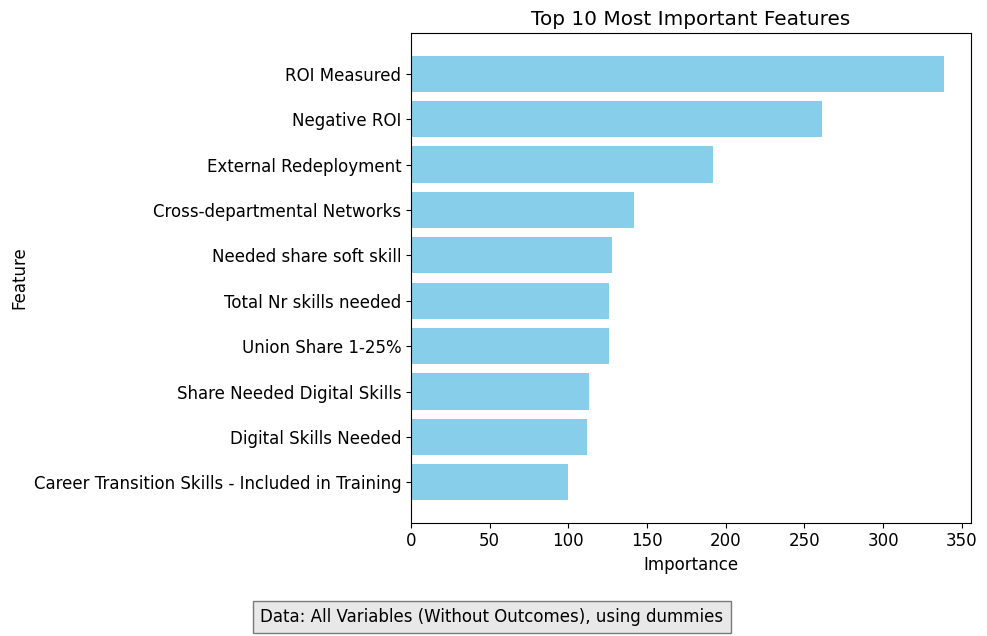

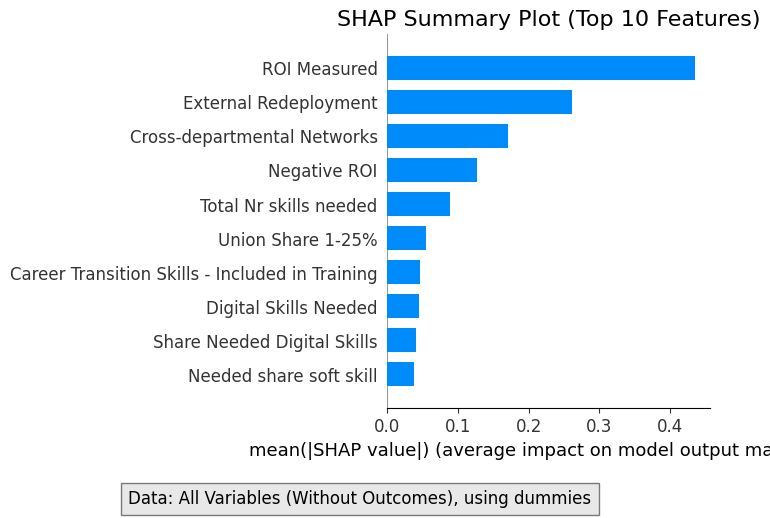

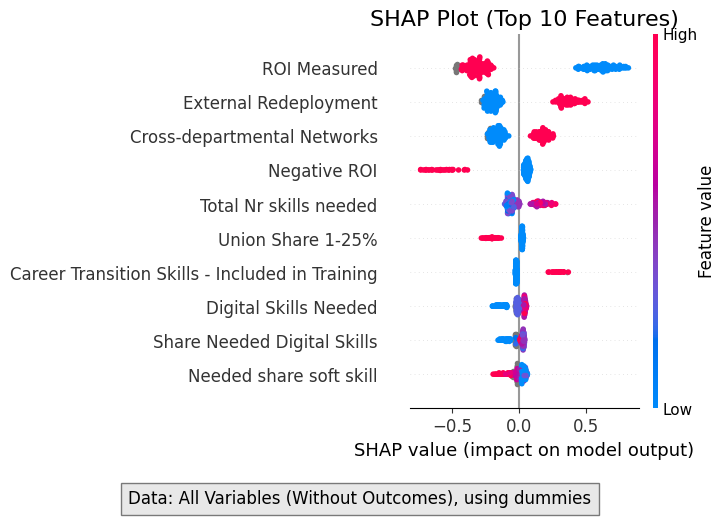

In [7]:
# Create a copy of the data to work with
all_data_no_outcomes = preprocess_data(data)

# Create target variable - Reskilling = 1, Upskilling = 0
target_all_no_outcomes = create_target(data)

# Remove target columns from feature set
X_all_no_out = all_data_no_outcomes.drop(['program_Reskilling', 'program_Upskilling', 'program_General'], axis=1, errors='ignore')

# Now remove outcome variables
outcome_columns = [col for col in X_all_no_out.columns if any(out in col for out in outcomes_to_exclude)]
X_all_no_out = X_all_no_out.drop(outcome_columns, axis=1, errors='ignore')
y_all_no_out = target_all_no_outcomes

# Split the data
X_train_all_no_out, X_val_all_no_out, y_train_all_no_out, y_val_all_no_out = train_test_split(
    X_all_no_out, y_all_no_out, test_size=0.2, random_state=42, stratify=y_all_no_out
)

# Train XGBoost model
all_no_out_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

all_no_out_model.fit(X_train_all_no_out, y_train_all_no_out, 
                    eval_set=[(X_val_all_no_out, y_val_all_no_out)], 
                    verbose=False)

# Get feature importances and sort them
all_no_out_importance = all_no_out_model.get_booster().get_score(importance_type='weight')
all_no_out_importance = {label_mapping.get(k, k): v for k, v in all_no_out_importance.items()}
all_no_out_sorted = sorted(all_no_out_importance.items(), key=lambda x: x[1], reverse=True)
all_no_out_top_10 = all_no_out_sorted[:10]
all_no_out_features, all_no_out_importances = zip(*all_no_out_top_10)
ordered_all_no_out_features = list(all_no_out_features)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(ordered_all_no_out_features)), list(reversed(all_no_out_importances)), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.figtext(0.5, -0.05, "Data: All Variables (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig('top10_features_all_data_no_outcomes.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate SHAP values
all_no_out_explainer = shap.Explainer(all_no_out_model, X_train_all_no_out)
all_no_out_shap_values = all_no_out_explainer(X_val_all_no_out)

# Create feature name mapping
all_no_out_feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val_all_no_out.columns)}

# Find indices of top 10 features
all_no_out_top_indices = []
for feature_name in ordered_all_no_out_features:
    # Try exact match first
    if feature_name in all_no_out_feature_map:
        all_no_out_top_indices.append(all_no_out_feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in all_no_out_feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            all_no_out_top_indices.append(all_no_out_feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 10 features
X_val_all_no_out_top10 = X_val_all_no_out.iloc[:, all_no_out_top_indices]
all_no_out_shap_top10 = all_no_out_shap_values.values[:, all_no_out_top_indices]

# Create SHAP explanation object with correct ordering
all_no_out_shap_top10_obj = shap.Explanation(
    values=all_no_out_shap_top10,
    base_values=all_no_out_shap_values.base_values,
    data=X_val_all_no_out_top10.values,
    feature_names=ordered_all_no_out_features
)

# Plot 1: SHAP bar plot with ordered features
plt.figure(figsize=(14, 8))
shap.summary_plot(
    all_no_out_shap_top10_obj,
    X_val_all_no_out_top10,
    feature_names=ordered_all_no_out_features,
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: All Variables (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_summary_top10_all_no_outcomes.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: SHAP plot with SAME top 10 features and SAME order
plt.figure(figsize=(14, 10))
shap.summary_plot(
    all_no_out_shap_top10_obj,  # Use the SAME top 10 SHAP values object
    X_val_all_no_out_top10,     # Use the SAME top 10 features data
    feature_names=ordered_all_no_out_features,  # Use the SAME feature names
    max_display=10,  # Only show top 10
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: All Variables (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig('shap_beeswarm_top10_all_no_outcomes.png', dpi=300, bbox_inches='tight')
plt.show()

## Appendix: Additional Model Results
This appendix compares the results of the four modeling approaches:
1. All variables (including outcomes)
2. Only program features (with dummies)
3. Program features with categorical encoding (without dummies)
4. All variables without outcomes (with dummies)

APPENDIX: ADDITIONAL RESULTS

1. PERFORMANCE METRICS

Model 1: All variables (with outcomes)
  Accuracy:  0.8264
  Precision: 0.8000
  Recall:    0.9185
  F1 Score:  0.8552
  AUC:       0.9133

Model 2: Program features (with dummies)
  Accuracy:  0.6736
  Precision: 0.6573
  Recall:    0.8667
  F1 Score:  0.7476
  AUC:       0.7621

Model 3: Program features (with categorical encoding)
  Accuracy:  0.7645
  Precision: 0.7241
  Recall:    0.9333
  F1 Score:  0.8155
  AUC:       0.8832

Model 4: All variables without outcomes
  Accuracy:  0.8223
  Precision: 0.7987
  Recall:    0.9111
  F1 Score:  0.8512
  AUC:       0.9118



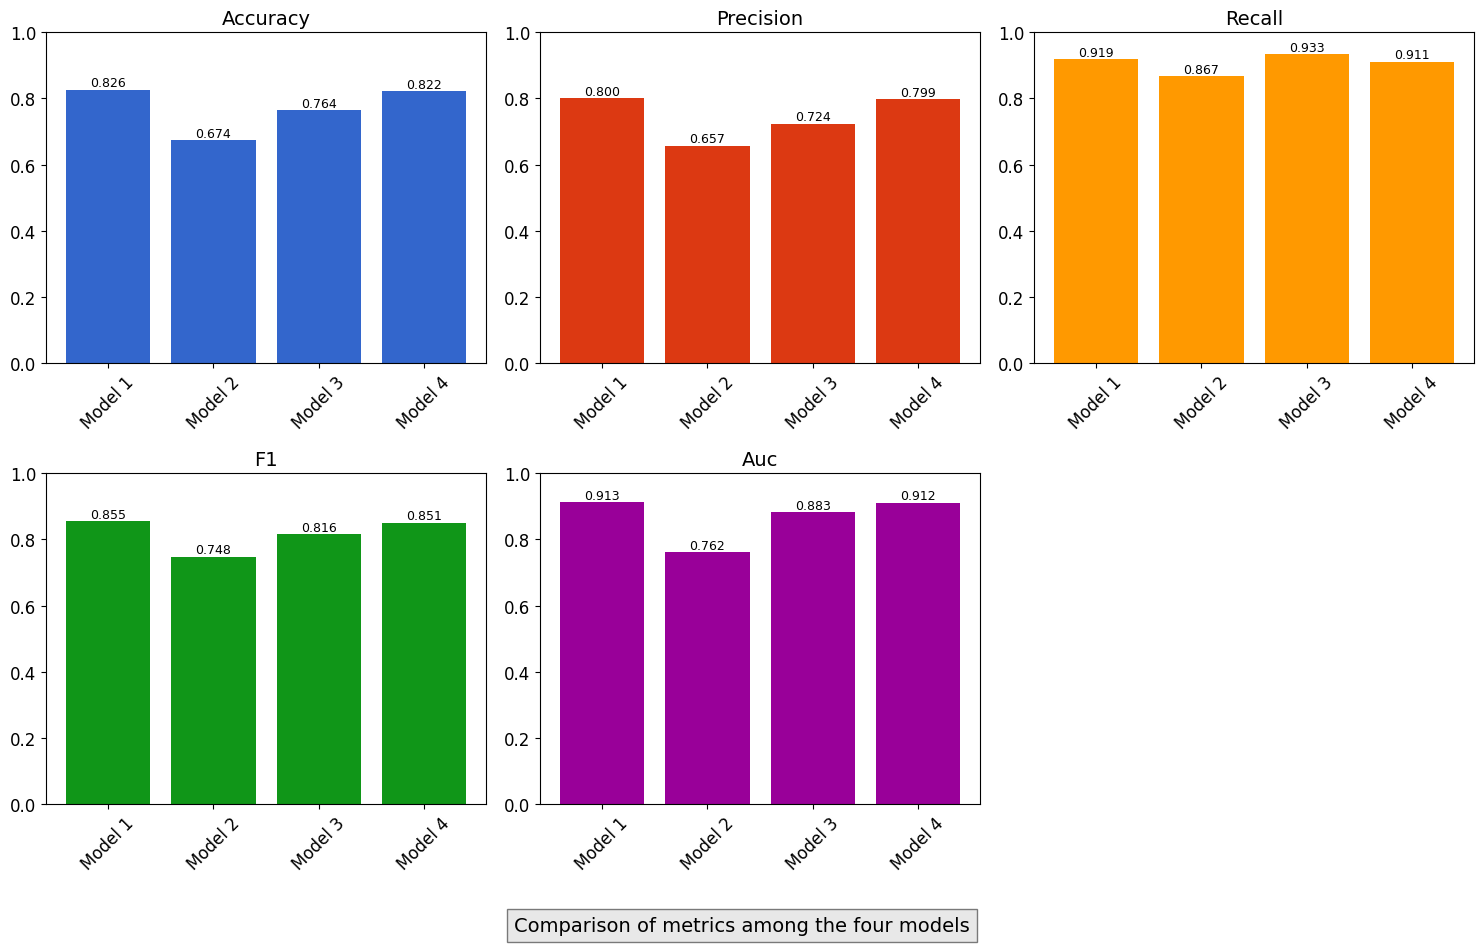

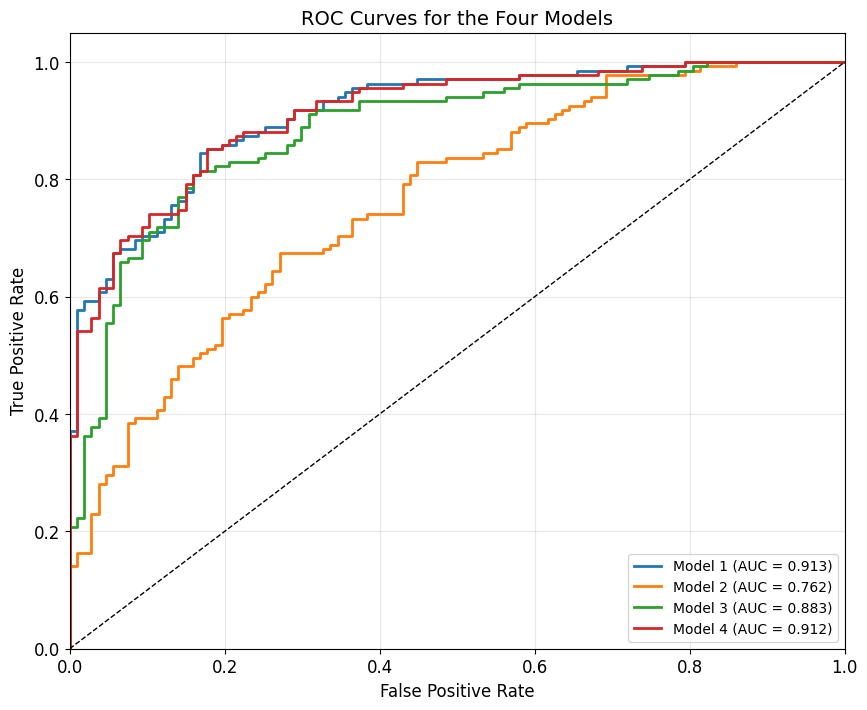

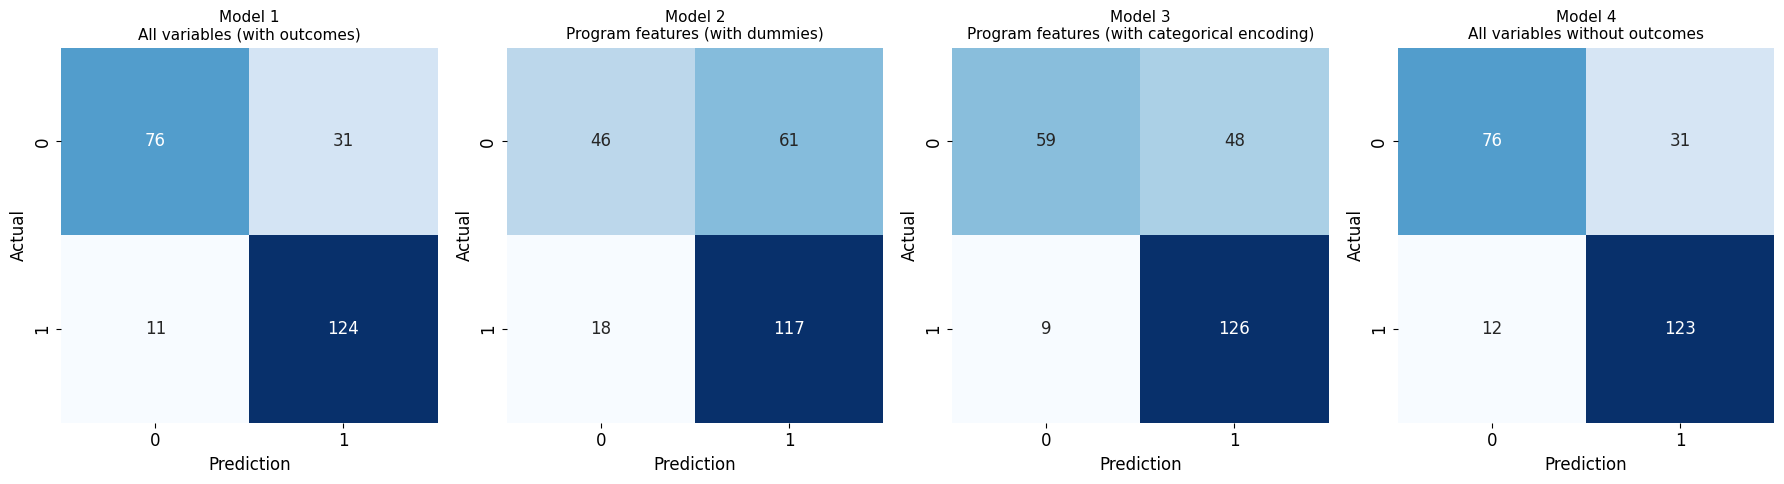


5. TOP 25 FEATURES FOR THE BEST MODEL: All variables (with outcomes)



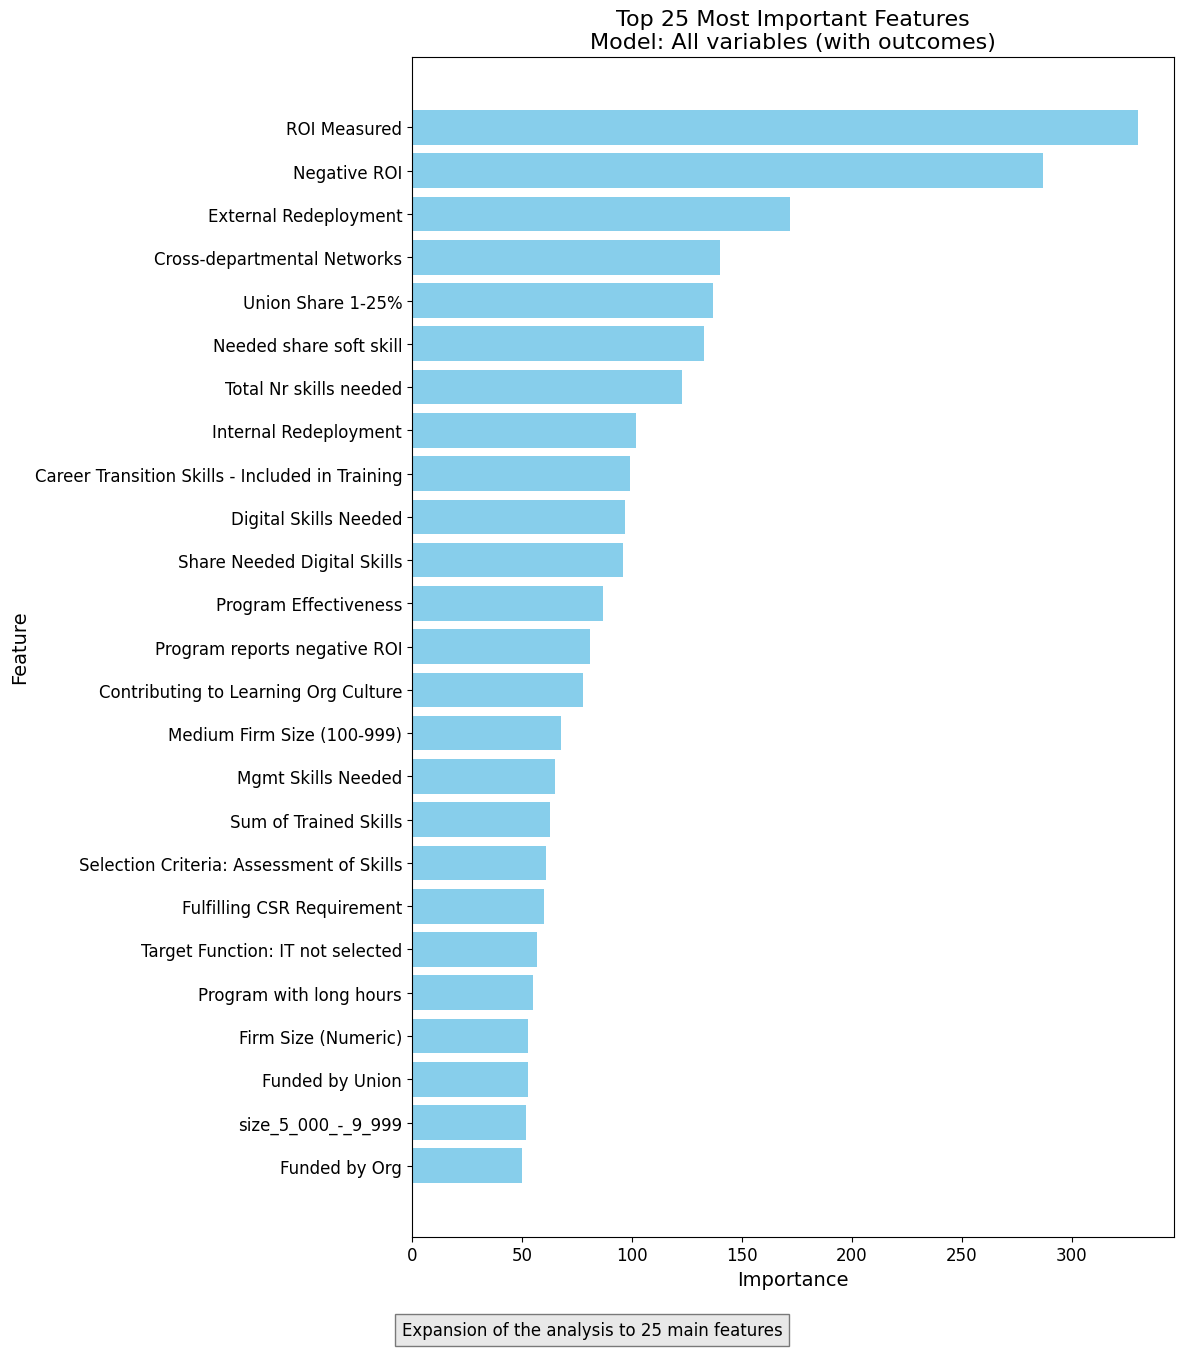


6. ANALYSIS OF MISCLASSIFICATIONS

Total samples in validation: 242
Correct classifications: 200 (82.6%)
Incorrect classifications: 42 (17.4%)


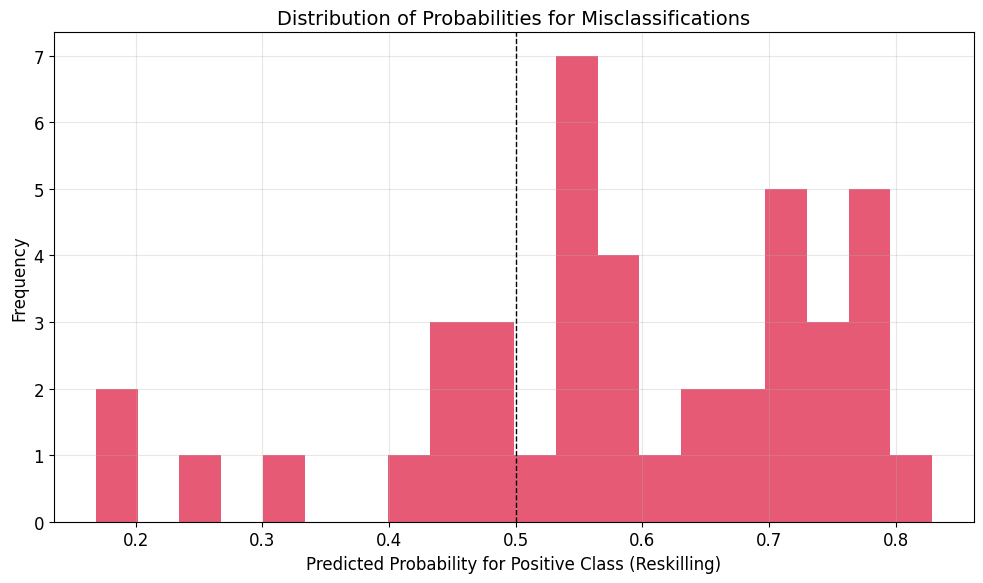


7. CONCLUSIONS

The results show:
- The model with the best overall performance (AUC) is: All variables (with outcomes)
- The use of categorical variables with encoding resulted in a better performance than using dummies.
  AUC with categorical encoding: 0.8832
  AUC with dummies: 0.7621
- Including outcome variables results in a improvement of the model.
  AUC with outcome variables: 0.9133
  AUC without outcome variables: 0.9118

This analysis demonstrates the importance of feature selection and categorical variable encoding
in model performance for distinguishing between Upskilling and Reskilling programs.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix
)
from matplotlib.gridspec import GridSpec
import seaborn as sns

print("=" * 80)
print("APPENDIX: ADDITIONAL RESULTS")
print("=" * 80)

# List of models, names, and validation datasets
models = [model, prog_model, cat_model, all_no_out_model]
model_names = [
    "All variables (with outcomes)",
    "Program features (with dummies)",
    "Program features (with categorical encoding)",
    "All variables without outcomes"
]
val_sets = [
    (X_val, y_val),
    (X_val_prog, y_val_prog),
    (X_val_cat, y_val_cat),
    (X_val_all_no_out, y_val_all_no_out)
]

# 1. Performance metrics table
print("\n1. PERFORMANCE METRICS\n")
metrics_data = []

for i, (model, name, (X_val_set, y_val_set)) in enumerate(zip(models, model_names, val_sets)):
    y_pred = model.predict(X_val_set)
    y_pred_proba = model.predict_proba(X_val_set)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val_set, y_pred)
    precision = precision_score(y_val_set, y_pred)
    recall = recall_score(y_val_set, y_pred)
    f1 = f1_score(y_val_set, y_pred)
    auc = roc_auc_score(y_val_set, y_pred_proba)

    # Display results
    print(f"Model {i+1}: {name}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  AUC:       {auc:.4f}")
    print("")

    # Save for plots
    metrics_data.append({
        'model': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    })

metrics_df = pd.DataFrame(metrics_data)

# 2. Comparative visualization of metrics
plt.figure(figsize=(15, 10))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
colors = ['#3366cc', '#dc3912', '#ff9900', '#109618', '#990099']

# Create subplots
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i+1)
    bars = plt.bar(range(len(model_names)), metrics_df[metric], color=colors[i])
    plt.title(f'{metric.capitalize()}', fontsize=14)
    plt.xticks(range(len(model_names)), [f'Model {i+1}' for i in range(len(model_names))], rotation=45)
    plt.ylim([0, 1])

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', fontsize=9)

plt.figtext(0.5, 0.01, "Comparison of metrics among the four models",
           ha='center', fontsize=14, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. ROC curves for all models
plt.figure(figsize=(10, 8))
for i, (model, name, (X_val_set, y_val_set)) in enumerate(zip(models, model_names, val_sets)):
    y_pred_proba = model.predict_proba(X_val_set)[:, 1]
    fpr, tpr, _ = roc_curve(y_val_set, y_pred_proba)
    auc = roc_auc_score(y_val_set, y_pred_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'Model {i+1} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for the Four Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Confusion matrices for each model
fig = plt.figure(figsize=(18, 5))
for i, (model, name, (X_val_set, y_val_set)) in enumerate(zip(models, model_names, val_sets)):
    y_pred = model.predict(X_val_set)
    cm = confusion_matrix(y_val_set, y_pred)

    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Model {i+1}\n{name}', fontsize=11)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Top 25 most important features (expansion of top 10)
# For the best-performing model
best_model_idx = metrics_df['auc'].argmax()
best_model = models[best_model_idx]
best_model_name = model_names[best_model_idx]
X_val_best = val_sets[best_model_idx][0]

print(f"\n5. TOP 25 FEATURES FOR THE BEST MODEL: {best_model_name}\n")

# Get feature importances from the best model
feature_importance = best_model.get_booster().get_score(importance_type='weight')
feature_importance = {label_mapping.get(k, k): v for k, v in feature_importance.items()}
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_25_features = sorted_features[:25]
features, importances = zip(*top_25_features)

# Visualization
plt.figure(figsize=(12, 14))
plt.barh(list(reversed(features)), list(reversed(importances)), color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title(f'Top 25 Most Important Features\nModel: {best_model_name}', fontsize=16)
plt.figtext(0.5, 0.01, "Expansion of the analysis to 25 main features",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('top25_features_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Analysis of specific categories:
# Correctly classified cases vs incorrectly classified cases
best_X_val = val_sets[best_model_idx][0]
best_y_val = val_sets[best_model_idx][1]
best_y_pred = best_model.predict(best_X_val)

# Identify correct and incorrect cases
correct_indices = best_y_val == best_y_pred
incorrect_indices = ~correct_indices

# SHAP analysis for misclassified cases
print("\n6. ANALYSIS OF MISCLASSIFICATIONS\n")
print(f"Total samples in validation: {len(best_y_val)}")
print(f"Correct classifications: {sum(correct_indices)} ({sum(correct_indices)/len(best_y_val)*100:.1f}%)")
print(f"Incorrect classifications: {sum(incorrect_indices)} ({sum(incorrect_indices)/len(best_y_val)*100:.1f}%)")

# Calculate predicted probabilities for misclassified samples
best_y_pred_proba = best_model.predict_proba(best_X_val)[:, 1]
incorrect_probas = best_y_pred_proba[incorrect_indices]

# Histogram of probabilities for misclassifications
plt.figure(figsize=(10, 6))
plt.hist(incorrect_probas, bins=20, alpha=0.7, color='crimson')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Predicted Probability for Positive Class (Reskilling)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Probabilities for Misclassifications', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('incorrect_classifications_proba_dist.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n7. CONCLUSIONS\n")
print("The results show:")

# Identify the best model based on AUC
best_model_name = model_names[metrics_df['auc'].argmax()]
print(f"- The model with the best overall performance (AUC) is: {best_model_name}")

# Compare the use of categorical variables vs dummies
cat_idx = 2  # Index of the categorical model
dummy_idx = 1  # Index of the model with dummies
cat_auc = metrics_df.iloc[cat_idx]['auc']
dummy_auc = metrics_df.iloc[dummy_idx]['auc']

comparison = "better" if cat_auc > dummy_auc else "worse"
print(f"- The use of categorical variables with encoding resulted in a {comparison} performance than using dummies.")
print(f"  AUC with categorical encoding: {cat_auc:.4f}")
print(f"  AUC with dummies: {dummy_auc:.4f}")

# Analyze the impact of including outcome variables
outcome_idx = 0  # Index of the model with outcome variables
no_outcome_idx = 3  # Index of the model without outcome variables
outcome_auc = metrics_df.iloc[outcome_idx]['auc']
no_outcome_auc = metrics_df.iloc[no_outcome_idx]['auc']

outcome_impact = "improvement" if outcome_auc > no_outcome_auc else "deterioration"
print(f"- Including outcome variables results in a {outcome_impact} of the model.")
print(f"  AUC with outcome variables: {outcome_auc:.4f}")
print(f"  AUC without outcome variables: {no_outcome_auc:.4f}")

print("\nThis analysis demonstrates the importance of feature selection and categorical variable encoding")
print("in model performance for distinguishing between Upskilling and Reskilling programs.")